In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-10-26 12:10:44.707825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761480645.165713     210 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761480645.273693     210 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

In [3]:
BATCH_SIZE = 16 # Number of images to process at a time
IMG_WIDTH = 224  # The width of the images to resize to
IMG_HEIGHT = 224 # The height of the images to resize to

In [4]:
print("Creating the training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True  # Correct: Always shuffle training data
)

print("Creating the validation dataset...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'valid'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False # Correct: No need to shuffle validation data
)

test_dir = "/kaggle/input/new-plant-diseases-dataset/test"
print("Test dir: ",os.path.join(test_dir, 'test'))
print("Creating the test dataset...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(test_dir, 'test'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    labels=None, # Correct: No labels for a single-directory test set
    shuffle=False # Correct: Never shuffle test data
)

Creating the training dataset...
Found 70295 files belonging to 38 classes.


I0000 00:00:1761480741.064734     210 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761480741.065372     210 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Creating the validation dataset...
Found 17572 files belonging to 38 classes.
Test dir:  /kaggle/input/new-plant-diseases-dataset/test/test
Creating the test dataset...
Found 33 files.


In [5]:
class_names = train_dataset.class_names
print("Class names: ",class_names)

Class names:  ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Toma

In [38]:
num_classes = len(class_names)

model = Sequential([
    # Rescale pixel values to the [0, 1] range
    Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Convolutional base for feature extraction
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers for classification
    Dense(128, activation='relu'),
    # CORRECTED: Output layer with the correct number of classes
    Dense(num_classes, activation='softmax')
])

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Stop after 5 epochs of no improvement
    restore_best_weights=True
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']
)

In [40]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [41]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [55]:
model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 117s 27ms/step - accuracy: 0.9760 - loss: 0.0742 - val_accuracy: 0.9343 - val_loss: 0.2305
Epoch 2/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 117s 27ms/step - accuracy: 0.9840 - loss: 0.0503 - val_accuracy: 0.9290 - val_loss: 0.2467
Epoch 3/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 116s 26ms/step - accuracy: 0.9860 - loss: 0.0432 - val_accuracy: 0.9251 - val_loss: 0.2897
Epoch 4/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 117s 27ms/step - accuracy: 0.9893 - loss: 0.0341 - val_accuracy: 0.9325 - val_loss: 0.2627
Epoch 5/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 117s 27ms/step - accuracy: 0.9902 - loss: 0.0313 - val_accuracy: 0.9428 - val_loss: 0.2327


In [56]:
# Assuming your 'model' is already compiled and trained
test_loss, test_acc = model.evaluate(validation_dataset, verbose=1)
print("Test Accuracy: ", test_acc)
print("Test Loss: ",test_loss)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9415 - loss: 0.2047
Test Accuracy:  0.934270441532135
Test Loss:  0.2305191606283188


In [57]:
predictions = model.predict(test_dataset)
print(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
[[1.2544577e-12 1.4873248e-14 9.9816883e-01 ... 9.1667003e-09
  3.1319634e-09 7.0747262e-17]
 [3.5905832e-05 7.5447183e-06 2.9163441e-01 ... 1.0055294e-05
  6.7610002e-09 1.4564103e-05]
 [1.6448819e-08 1.1505762e-10 5.9460968e-01 ... 1.8680383e-06
  2.3166475e-09 9.1475894e-09]
 ...
 [1.7201189e-09 3.9905226e-15 7.0100628e-05 ... 9.9919885e-01
  1.5807392e-12 4.0341418e-16]
 [5.8936159e-08 9.2076235e-14 6.9246307e-04 ... 9.4324225e-01
  1.6503281e-15 1.3483192e-14]
 [3.7399086e-12 5.4724532e-14 4.3982428e-08 ... 9.9998510e-01
  5.7210882e-17 1.0812035e-17]]


In [58]:
class_names_list = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


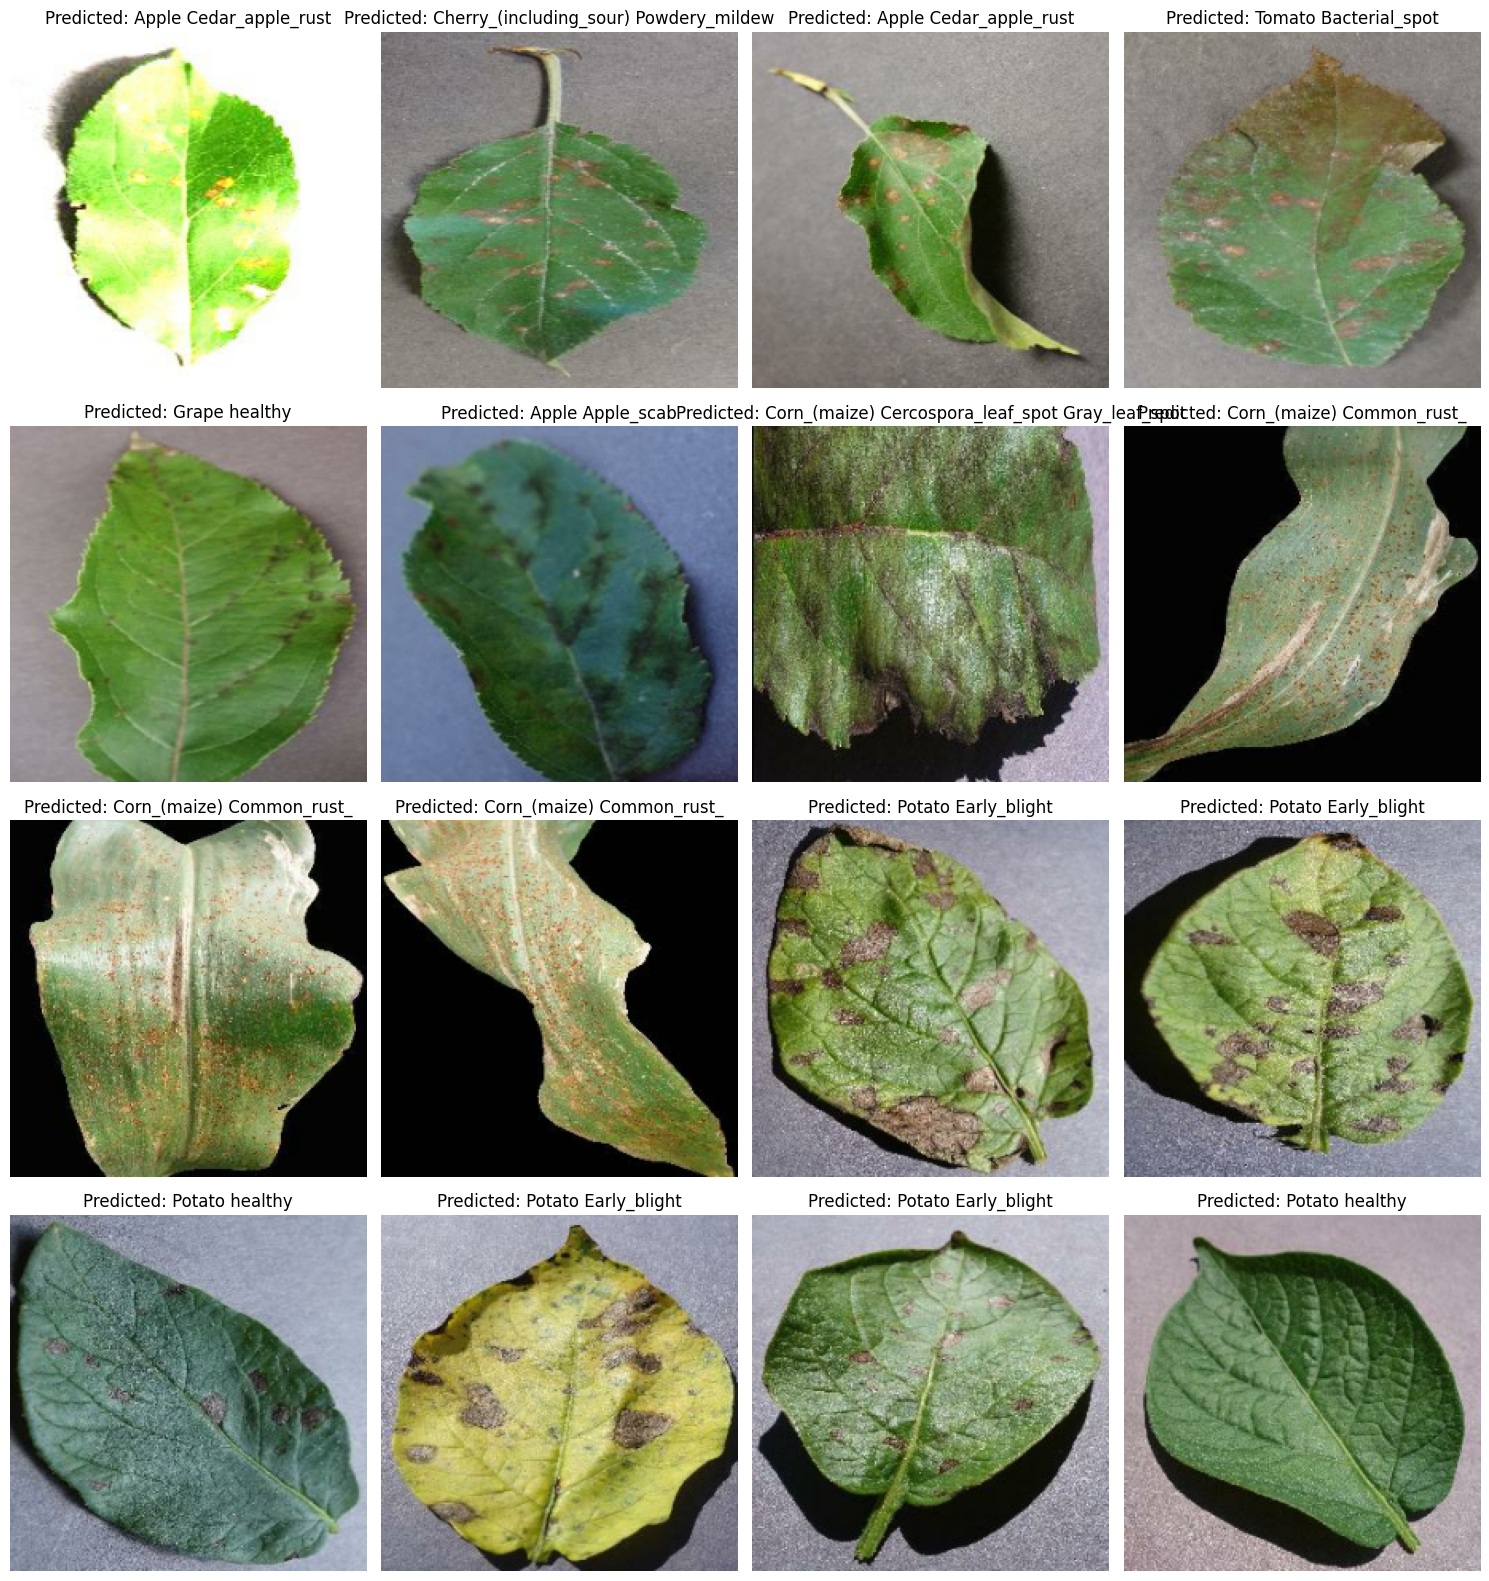

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


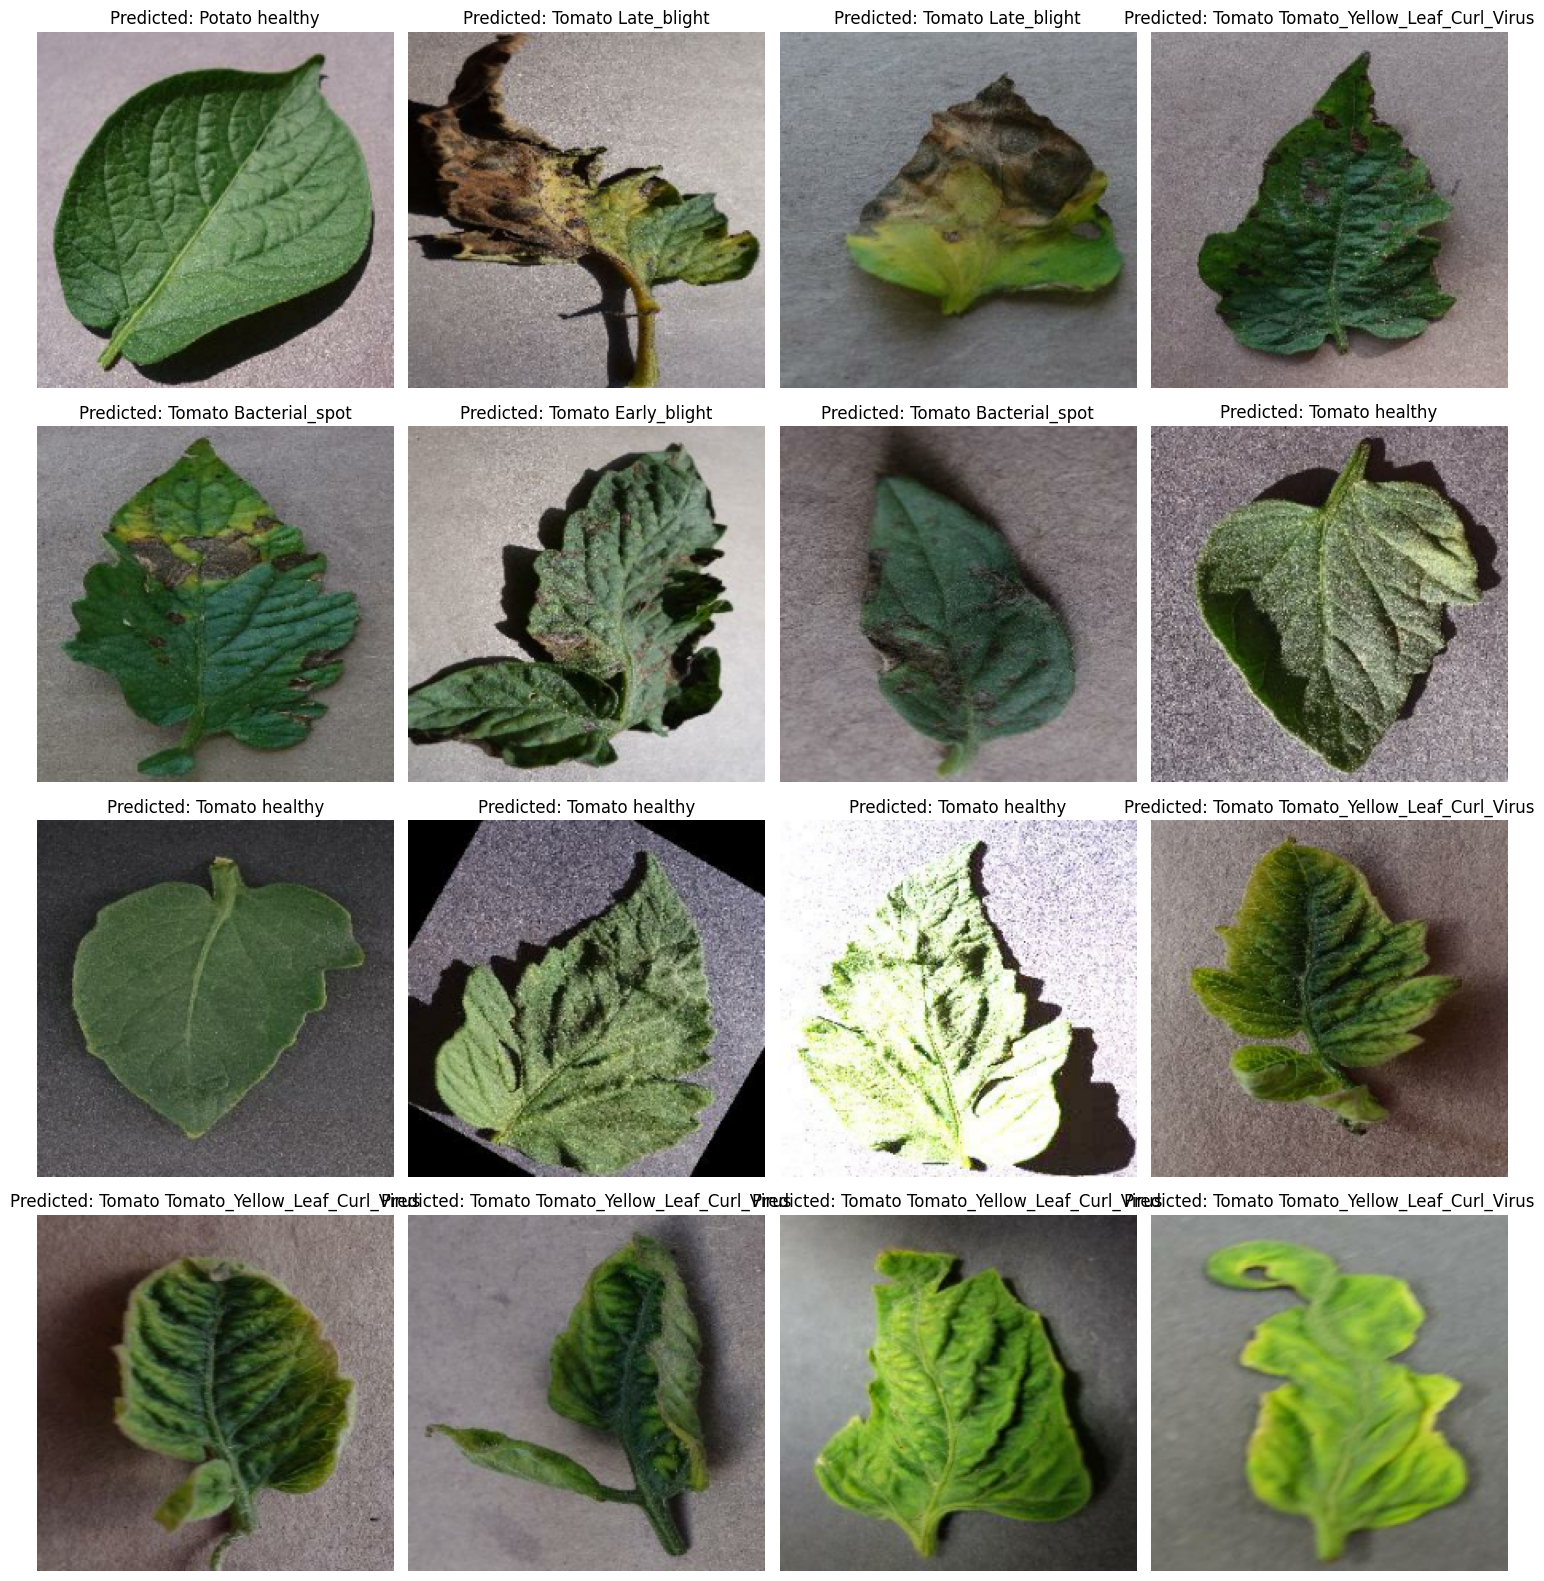

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


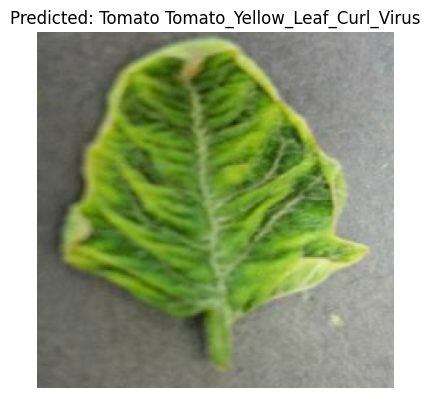

In [65]:
import math

# Loop through every batch in test_dataset
for batch_idx, images in enumerate(test_dataset):
    predictions = model.predict(images)

    # Plot each image in the batch
    num_images = len(images)
    cols = 4
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(15, rows * 4))

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_index = np.argmax(predictions[i])
        predicted_class = class_names[predicted_index]
        plt.title(f"Predicted: {predicted_class.replace('___', ' ')}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [74]:
model.save("PlantDiseaseModel.keras")

In [75]:
loadedModel = tf.keras.models.load_model("PlantDiseaseModel.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [76]:
test_folder = os.path.join(test_dir, 'test')

In [77]:
def loadImg(imgPath):
    img = tf.keras.preprocessing.image.load_img(imgPath, target_size=(IMG_WIDTH,IMG_HEIGHT))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0 
    return img_array

def predictImagesInFolder(testFolder):
    print(f"\n🔍 Running predictions on folder: {testFolder}\n")
    image_files = [
        f for f in os.listdir(testFolder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]

    if not image_files:
        print("⚠️ No image files found in the folder.")
        return

    for file in image_files:
        img_path = os.path.join(testFolder, file)
        img = loadImg(img_path)

        # Predict
        predictions = loadedModel.predict(img, verbose=0)
        predicted_index = np.argmax(predictions, axis=1)[0]
        predicted_class_name = class_names[predicted_index]

        # Print result
        print(f"📸 File: {file} → 🧠 Predicted class: {predicted_class_name}")

In [78]:
predictImagesInFolder(test_folder)


🔍 Running predictions on folder: /kaggle/input/new-plant-diseases-dataset/test/test

📸 File: TomatoEarlyBlight6.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: TomatoYellowCurlVirus4.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: TomatoYellowCurlVirus6.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: PotatoHealthy2.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: TomatoYellowCurlVirus5.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: PotatoEarlyBlight2.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: TomatoYellowCurlVirus3.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: TomatoEarlyBlight3.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: CornCommonRust2.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: AppleScab3.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: TomatoEarlyBlight5.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: TomatoHealthy2.JPG → 🧠 Predicted class: Tomato___Late_blight
📸 File: CornCommonRust1.JPG → 🧠 Predicted

In [79]:
loadedModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,347,726 (85.25 MB)

 Trainable params: 11,173,862 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,173,864 (42.62 MB)